# Inferring Synaptic Weights from Network Activity

Here we compare plausible methods for overcoming the ''weight transport'' problem.

<img src="./WeightTransportIllustration.png" width=80%>

The illustration above depicts this issue. See the middle pane for the mathematical origin of the requirement of feedforward weight matrices for the error backpropagation.

There are two key and recent methods which propose that the feedback error connectivity could be __learned__ by an inference process based upon the activity of the pre and post-synaptic neurons. These are regression discontinuity design (RDD) [1], and a rate-based method which we refer to as the Akrout method [2].

We compare these methods against a simple and powerful method inspired by the analytic solution to a leaky-integrate and fire neuron.
We refer to this method as Spike Timing-Dependent Weight Inference.

[1] Guerguiev J, Kording KP, Richards BA. Spike-based causal inference for weight alignment. arXiv [q-bio.NC]. 2019. Available: http://arxiv.org/abs/1910.01689 

[2] Akrout, M., Wilson, C., Humphreys, P. C., Lillicrap, T., & Tweed, D. (2019). Deep Learning without Weight Transport. In arXiv [cs.LG]. arXiv. http://arxiv.org/abs/1904.05391

In [1]:
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

from weight_inference import simulator
from weight_inference import methods
from weight_inference import fitter

In [2]:
# Function to plot spike train without borders:
def plot_spike_train(spike_trains, simulation_time, color='k', alpha='1.0', size=2500):
    nb_units = len(spike_trains)
    for i in range(nb_units):
        spikes = spike_trains[i][spike_trains[i] < simulation_time]
        plt.scatter(spikes, i*np.ones((len(spikes))),
                    marker="|", s=(size/nb_units), color=color, alpha=alpha)
    
    # Getting rid of bounding box
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return ax

Setting up the network shape, synaptic weights, and input stimulation

In [3]:
# Network Shape
nb_input_neurons, nb_output_neurons = 100, 10

# Simulation details
simulation_time = 2e5 #ms
timestep = 0.25 #ms
nb_timesteps = simulation_time // timestep

# Stimulation Generation
ratio_stimulated = 0.2
stimulation_spike_trains = simulator.poisson_spike_train(
        nb_input_neurons, 200/1000, simulation_time, timestep) # 200Hz stimulation
stimulation_spike_trains = simulator.random_sample_spike_train(
    stimulation_spike_trains, simulation_time, timestep, 100, ratio_stimulated) # resampling every 100ms with probability 0.1

# Stimulation->Input weights
# Creating weight matrices from stimulation to input and input to output
stim_scale = 10.0
stim_input_weights = stim_scale*np.eye(nb_input_neurons, nb_input_neurons) # One to one with a particular scale

# Input->Output neuron synaptic weight matrix
input_scale = 7.5*stim_scale # Compensating for hidden layer mean weight, firing rates and number)
r = np.random.RandomState(seed=42)
input_output_weights = input_scale*((np.sqrt(0.2)/np.sqrt(nb_input_neurons*ratio_stimulated))*r.normal(size=(nb_output_neurons, nb_input_neurons)) + (1 / (nb_input_neurons*ratio_stimulated)))


### Simulating the network activity

In [4]:
# Computing stimulation to input neurons
stimulation_xpsps = simulator.spike_trains_to_xpsps(stimulation_spike_trains, simulation_time, timestep)

# Computing input neuron activity
input_neuron_acc, input_neuron_mem, input_neuron_spike_trains = simulator.lif_dynamics(
        stimulation_xpsps, stim_input_weights, timestep)
input_neuron_xpsps = simulator.spike_trains_to_xpsps(input_neuron_spike_trains, simulation_time, timestep)

# Computing output neuron activity
output_neuron_acc, output_neuron_mem, output_neuron_spike_trains = simulator.lif_dynamics(
        input_neuron_xpsps, input_output_weights, timestep)
output_neuron_xpsps = simulator.spike_trains_to_xpsps(output_neuron_spike_trains, simulation_time, timestep)

### Visualising network activity

Text(0, 0.5, 'Output Neuron ID')

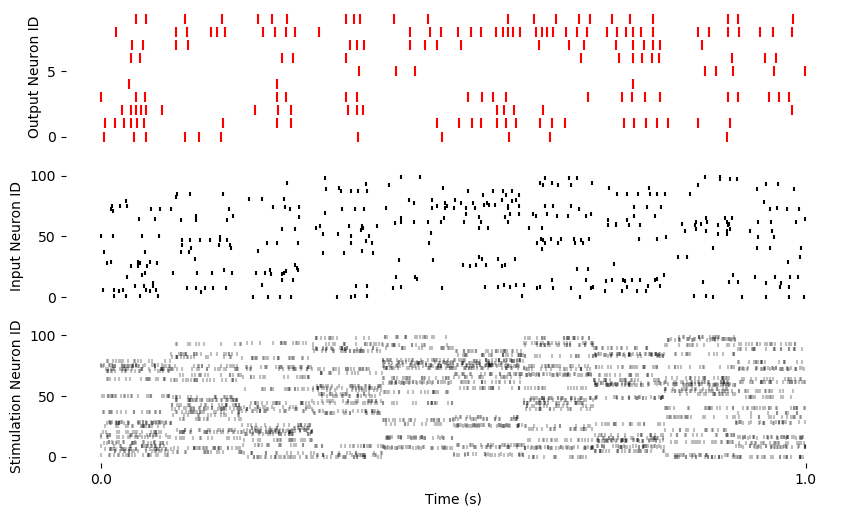

In [5]:
plt.figure(figsize=(10,6), dpi=100)

plt.subplot(3,1,3)
ax = plot_spike_train(stimulation_spike_trains, 1e3, alpha=0.25, size=500)
plt.xticks([0.0, 1e3], [0.0, 1.0])
plt.xlabel("Time (s)")
plt.ylabel("Stimulation Neuron ID")

plt.subplot(3,1,2)
ax = plot_spike_train(input_neuron_spike_trains, 1e3, size=500)
plt.xticks([])
plt.ylabel("Input Neuron ID")

plt.subplot(3,1,1)
ax = plot_spike_train(output_neuron_spike_trains, 1e3, size=500, color='red')
plt.xticks([])
plt.ylabel("Output Neuron ID")

### Inferring synaptic weights from activity

In [6]:
# Starting with a zero-centred small variance guess
initial_guess_matrix = 0.001*(r.uniform(size=(nb_output_neurons, nb_input_neurons)) - 0.5)
learning_rate = 5e-4
check_interval = 10

In [ ]:
batch_size = 10
akrout_guesses = fitter.akrout(
            initial_guess_matrix,
            input_neuron_spike_trains,
            output_neuron_spike_trains,
            simulation_time,
            100,  # resample period
            10,   # batch size
            learning_rate,
            check_interval)

tau_fast, tau_slow = 10.0, 200.0
stdwi_guesses = fitter.stdwi(
                initial_guess_matrix,
                input_neuron_spike_trains,
                output_neuron_spike_trains,
                simulation_time,
                100,
                timestep,
                tau_fast/tau_slow, tau_slow,
                1.0, tau_fast,
                learning_rate, check_interval)

alpha = 0.05
window_size = 40
rdd_guesses = fitter.rdd(
                initial_guess_matrix,
                input_neuron_mem,
                input_neuron_acc,
                output_neuron_xpsps,
                alpha, window_size,
                1.0, # Spiking threshold
                timestep,
                learning_rate,
                check_interval)

In [ ]:
plt.figure(figsize=(12,4))
xmax = np.max(np.abs(input_output_weights.flatten()))*1.1

plt.subplot(1,3,1)
plt.scatter(input_output_weights.flatten(), akrout_guesses[-1].flatten(), alpha=0.25)
plt.xlim([-xmax, xmax])
plt.ylim([-1.1*np.max(np.abs(akrout_guesses[-1].flatten())), 1.1*np.max(np.abs(akrout_guesses[-1].flatten()))])
plt.title("Akrout Method")

plt.subplot(1,3,2)
plt.scatter(input_output_weights.flatten(), stdwi_guesses[-1].flatten(), alpha=0.25)
plt.xlim([-xmax, xmax])
plt.ylim([-1.1*np.max(np.abs(stdwi_guesses[-1].flatten())), 1.1*np.max(np.abs(stdwi_guesses[-1].flatten()))])
plt.title("STDWI Method")

plt.subplot(1,3,3)
plt.scatter(input_output_weights.flatten(), rdd_guesses[-1].flatten(), alpha=0.25)
plt.xlim([-xmax, xmax])
plt.ylim([-1.1*np.max(np.abs(rdd_guesses[-1].flatten())), 1.1*np.max(np.abs(rdd_guesses[-1].flatten()))])
plt.title("RDD Method")

### Measuring accuracies

In [ ]:
pearson_correlations = [[], [], []]
sign_accuracies = [[], [], []]

results = [akrout_guesses, stdwi_guesses, rdd_guesses]

for r_indx in range(len(results)):
    for r_guess in results[r_indx]:
        pearson_correlations[r_indx].append(spstats.pearsonr(r_guess.flatten(), input_output_weights.flatten())[0])
        sign_accuracies[r_indx].append(methods.sign_alignment(r_guess.flatten(), input_output_weights.flatten()))

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Pearson Correlation Comparison')
plt.plot(pearson_correlations[0], label='Akrout')
plt.plot(pearson_correlations[1], label='STDWI')
plt.plot(pearson_correlations[2], label='RDD')
plt.xlabel("Simulation Time (s)")
plt.ylabel("Pearson Correlation Coefficient (r)")

plt.legend()
plt.subplot(1,2,2)
plt.title('Sign Alignment Comparison')
plt.plot(sign_accuracies[0], label='Akrout')
plt.plot(sign_accuracies[1], label='STDWI')
plt.plot(sign_accuracies[2], label='RDD')
plt.xlabel("Simulation Time (s)")
plt.ylabel("Sign Alignment -- ratio")
plt.legend()